Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan 

https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center

Plan

EDA

BUILD
- Decide how do we want to evaluate our results --> accuracy, logloss, roc_auc
- Try to build a flexible combined pipeline for both text and numerical data

MODEL SELECTION
- Try models you have learned about
    * Logistic Regression
    * Knn
    * Bagging and random forest
    * Adaboost, Gradient boost, Stochastic gradient boosting

MODEL TUNING
- Select 2-3 best ones and proceed with hyperparamter tuning for each

EVALUATE RESULTS
- Summarize tradeoffs and implications of the models
- Why does it suit our data? What to be aware in the future if we are still going to use this model with new data

EXPLAIN
- Write a nice notebook and tell a story!

# EDA

In [86]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
# read csv and rename columns
df = pd.read_csv('transfusion.data', skiprows= 1, names=["Time since last donation (months)",
                                            "Donation count (times)",
                                            "Volume donated (cc)",
                                            "Time since first donation (months)",
                                            "Donated on March 2007"])
df.head()

,Time since last donation (months),Donation count (times),Volume donated (cc),Time since first donation (months),Donated on March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## Features
- "Time since last donation (months)"
- "Donation count (times)",
- "Volume donated (cc)",
- "Time since first donation (months)"

## Target variable
- "Donated on March 2007"

In [88]:
df.info()
# no nulls very nice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Time since last donation (months)   748 non-null    int64
 1   Donation count (times)              748 non-null    int64
 2   Volume donated (cc)                 748 non-null    int64
 3   Time since first donation (months)  748 non-null    int64
 4   Donated on March 2007               748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [89]:
# separate features and target
FEATURES = ["Time since last donation (months)",
            "Donation count (times)",
            "Volume donated (cc)",
            "Time since first donation (months)"]
X = df[FEATURES]

# convert outcome to category
# df["Donated on March 2007"] = df["Donated on March 2007"].astype('category')
y= df["Donated on March 2007"]

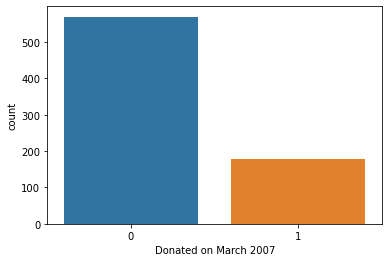

In [90]:
# look at total outcome
sns.countplot(data=df, x=df["Donated on March 2007"])
plt.show()

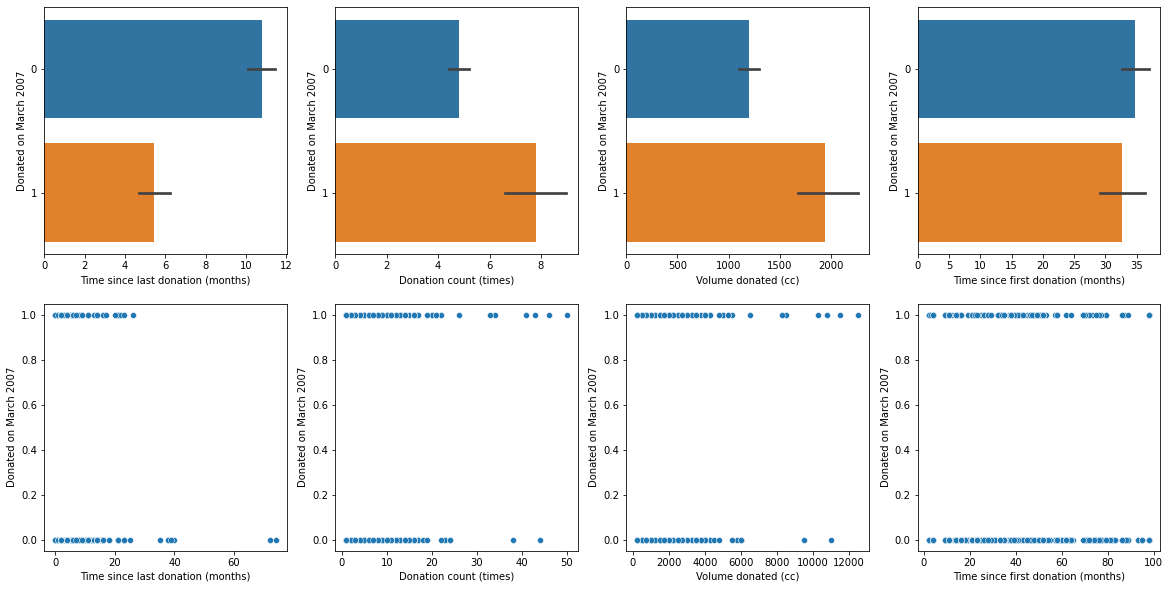

In [91]:
# look at the outcome for each feature
fig, ax = plt.subplots(2,4, figsize=(20,10))
for i in range(len(FEATURES)):
    sns.barplot(ax=ax[0][i], x=df[FEATURES[i]], y=df["Donated on March 2007"].astype('category'))
    sns.scatterplot(ax=ax[1][i], data=df, x=FEATURES[i], y="Donated on March 2007")
plt.show()

Time since last donation (months)
[<AxesSubplot:> <AxesSubplot:>]


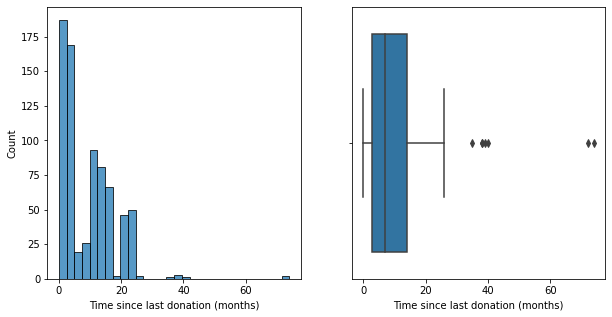

Donation count (times)
[<AxesSubplot:> <AxesSubplot:>]


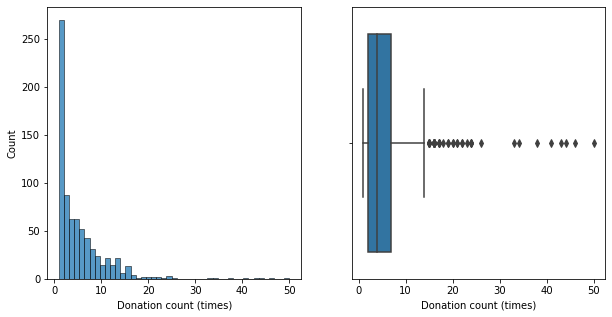

Volume donated (cc)
[<AxesSubplot:> <AxesSubplot:>]


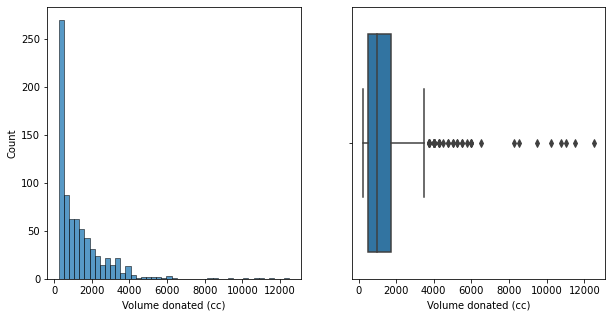

Time since first donation (months)
[<AxesSubplot:> <AxesSubplot:>]


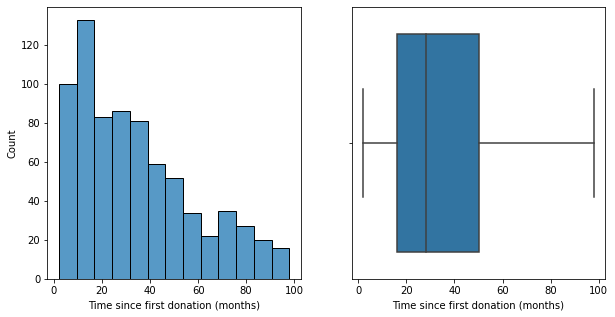

In [92]:
# look at the distributions of features
for f in FEATURES:
    print(f)
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    print(ax)
    sns.histplot(x=X[f], ax=ax[0])
    sns.boxplot(x=X[f], ax=ax[1])
    plt.show()

# features' scales are different we need to scale them
# features have some outliers consider a robust scaler
# features are rougly exponentially distributed --> consider tranform to normal dist with PowerTransformer

# Build

In [93]:
# split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# look at target ratios
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

0.23745819397993312
0.24


In [94]:
# sklearn imports

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, PowerTransformer

# classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# pipeline
from sklearn.pipeline import make_pipeline

# metrics
from sklearn.metrics import accuracy_score, log_loss, classification_report

In [98]:
# construct pipelines
scalers = [StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler(), PowerTransformer()]
clfs = [LogisticRegression(), 
                KNeighborsClassifier(),
                RandomForestClassifier(random_state=69),
                GradientBoostingClassifier(random_state=69)
                ]
pls = []
y_preds = []
y_pred_probas = []

for clf in clfs:
    # base model
    pl = make_pipeline(
                        clf
                        )
    # fit model
    pl.fit(X_train, y_train)
    pls.append(pl)
    # predict
    y_preds.append(pl.predict(X_test))
    y_pred_probas.append(pl.predict_proba(X_test))
    # with scaler
    for scaler in scalers:
        pl = make_pipeline(
                            scaler,
                            clf
                            )
        # fit model
        pl.fit(X_train, y_train)
        pls.append(pl)
        # predict
        y_preds.append(pl.predict(X_test))
        y_pred_probas.append(pl.predict_proba(X_test))

# look at result metrics
for i in range(len(pls)):
    print(pls[i])
    print('Accuracy = {}, Logloss = {}'.format(accuracy_score(y_test, y_preds[i]), log_loss(y_test, y_pred_probas[i])))
    print()

Pipeline(steps=[('logisticregression', LogisticRegression())])
Accuracy = 0.7733333333333333, Logloss = 0.49677459851531564

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7733333333333333, Logloss = 0.495446703548668

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7666666666666667, Logloss = 0.48728259594366136

Pipeline(steps=[('normalizer', Normalizer()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.76, Logloss = 0.5415191394463814

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7733333333333333, Logloss = 0.49521414281380394

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7933333333333333, Logloss = 0.4613192149330812

Pipeline(s

Pipeline(steps=[('logisticregression', LogisticRegression())])
Accuracy = 0.7733333333333333, Logloss = 0.49677459851531564

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7733333333333333, Logloss = 0.495446703548668

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7666666666666667, Logloss = 0.48728259594366136

Pipeline(steps=[('normalizer', Normalizer()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.76, Logloss = 0.5415191394463814

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7733333333333333, Logloss = 0.49521414281380394

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7933333333333333, Logloss = 0.4613192149330812

Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.74, Logloss = 2.465871871737545

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.7466666666666667, Logloss = 2.2260917299780076

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.7533333333333333, Logloss = 2.643659184592545

Pipeline(steps=[('normalizer', Normalizer()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.76, Logloss = 2.631156974132021

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.7533333333333333, Logloss = 2.4634333942244266

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.7333333333333333, Logloss = 2.2035439712916793

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7266666666666667, Logloss = 1.0602187136598458

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7266666666666667, Logloss = 1.0612762470474288

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7333333333333333, Logloss = 1.0576400108538038

Pipeline(steps=[('normalizer', Normalizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7866666666666666, Logloss = 0.947796620414028

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7333333333333333, Logloss = 1.0571004743766845

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.74, Logloss = 1.0516156863898678

Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.74, Logloss = 0.5777412211182509

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.7466666666666667, Logloss = 0.5765207168652389

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.7466666666666667, Logloss = 0.5765353501991716

Pipeline(steps=[('normalizer', Normalizer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.7933333333333333, Logloss = 0.5258120141778355

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.74, Logloss = 0.5778840869600254

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.7533333333333333, Logloss = 0.5743112217078018



# Hyperparameter tuning

In [107]:
# Normalizer + RandomForest 
# looks most promising with best accuracy and logloss


from sklearn.model_selection import GridSearchCV

# store pipelines here
pls = [make_pipeline(
                    Normalizer(),
                    RandomForestClassifier(random_state=69)
                    )] # include base models using default params for comparison]

# param_grid
rf_param_grid = {
                'randomforestclassifier__min_samples_split': [2,5,10],
                'randomforestclassifier__n_estimators': range(10,401,10)
                }
# create pipeline for rf, gb
rf_pl = make_pipeline(
                    Normalizer(),
                    RandomForestClassifier(random_state=69)
                    )
# Grid search
search = GridSearchCV(rf_pl, rf_param_grid, cv=3, n_jobs=-1)
search.fit(X_train, y_train)
pls.append(search.best_estimator_)
print(search.best_estimator_)

# Look at cv results
# print(search.cv_results_)
print("Best parameter {} (CV score={}):".format(search.best_params_, search.best_score_))

# try to plot the performance across the range of params
# plt.scatter(
#             x=[d['randomforestclassifier__n_estimators'] for d in search.cv_results_['params']],
#             y=search.cv_results_['mean_test_score']
#             )
# plt.title('GridSearchCV evaluating accuracy at n_estimators for RandomForestClassifier')
# plt.xlabel('n_estimators')
# plt.ylabel('cv accuracy')
# plt.show()

Pipeline(steps=[('normalizer', Normalizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=10, n_estimators=370,
                                        random_state=69))])
Best parameter {'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 370} (CV score=0.7491959798994975):


Pipeline(steps=[('normalizer', Normalizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7866666666666666, Logloss = 0.947796620414028
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       114
           1       0.61      0.31      0.41        36

    accuracy                           0.79       150
   macro avg       0.71      0.62      0.64       150
weighted avg       0.76      0.79      0.76       150



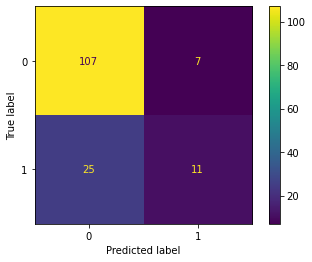

Pipeline(steps=[('normalizer', Normalizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=10, n_estimators=370,
                                        random_state=69))])
Accuracy = 0.7933333333333333, Logloss = 0.5256965201910403
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       114
           1       0.65      0.31      0.42        36

    accuracy                           0.79       150
   macro avg       0.73      0.63      0.64       150
weighted avg       0.77      0.79      0.76       150



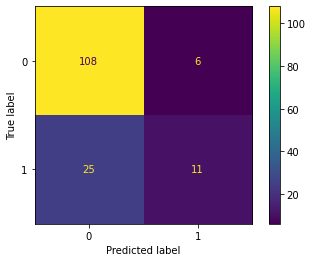

In [108]:
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix
# test on hold out set
for pl in pls:
    pl.fit(X_train, y_train)
    # make predictions
    y_pred = pl.predict(X_test)
    y_pred_proba = pl.predict_proba(X_test)

    # print results
    print(pl)
    print('Accuracy = {}, Logloss = {}'.format(accuracy_score(y_test, y_pred), log_loss(y_test, y_pred_proba)))

    # print classification report
    print(classification_report(y_test, y_pred))

    # plot confusion matrix, roc_auc
    plot_confusion_matrix(pl, X_test, y_test)
    plt.show()


Although very slighy, we see improvement in accuracy after parameter tuning.
Log loss got better 0.9xx --> 0.5xx